In [1]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

In [6]:
# Load data from csv
df = pd.read_csv('../TH_Data/100_rows.csv')
df['minmax_norm'] = 1 + (df['4'] - df['4'].min()) / (df['4'].max() - df['4'].min()) * 9
df['mean_norm'] = 1 + (df['4'] - df['4'].mean()) / (df['4'].max() - df['4'].min()) * 9
df.head()

# data = np.random.uniform(low=1.0, high=10.0, size=(5000,))

# ser = pd.Series(data)
# ser

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,minmax_norm,mean_norm
0,0,https://www.goodreads.com//book/show/40605251-...,A Game of Thrones,George R.R. Martin,"55,493 reviews",4.44,835,2005,The Lands of Ice and Fire,A Song of Ice and Fire #1,"Nebula Award Nominee for Best Novel (1997), Lo...","['Fantasy', 'Fiction', 'Fantasy']",7.18750,3.682188
1,1,https://www.goodreads.com//book/show/21787.The...,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,"1,836 reviews",4.60,1728,2012,Middle-earth,"The Lord of the Rings #0-3, Middle-earth Universe",NaN,"['Fantasy', 'Fiction', 'Classics']",8.68750,5.182187
2,2,https://www.goodreads.com//book/show/13812.Mag...,The Name of the Wind,Patrick Rothfuss,"43,979 reviews",4.52,662,2007,Middle-earth,The Kingkiller Chronicle #1,Locus Award Nominee for Best First Novel and B...,"['Fantasy', 'Fiction', 'Fantasy']",7.93750,4.432187
3,3,https://www.goodreads.com//book/show/40605251-...,The Way of Kings,Brandon Sanderson,"22,141 reviews",4.61,1007,2010,Roshar,"The Stormlight Archive #1, The Cosmere",Locus Award Nominee for Best Fantasy Novel (20...,"['Fantasy', 'Fiction', 'Fantasy']",8.78125,5.275937
4,4,https://www.goodreads.com//book/show/21787.The...,The Chronicles of Narnia,C.S. Lewis,"10,666 reviews",4.26,767,2002,"London, England (United Kingdom)",The Chronicles of Narnia (Publication Order) #...,NaN,"['Fantasy', 'Classics', 'Fiction']",5.50000,1.994687


Text(0, 0.5, 'Frequency')

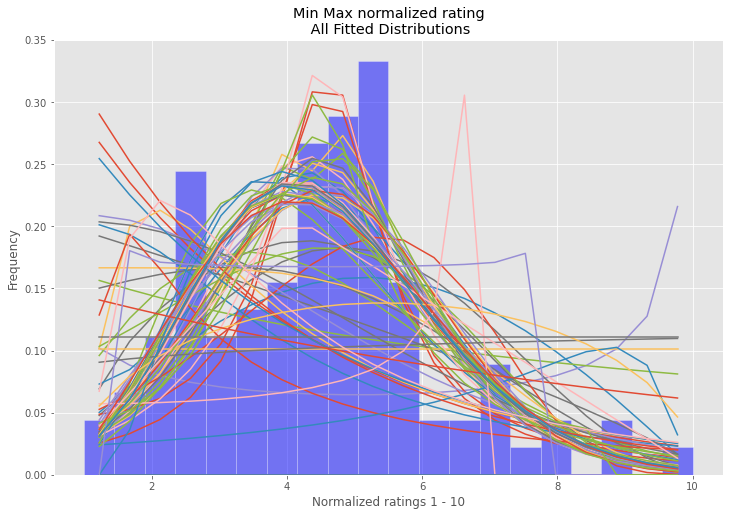

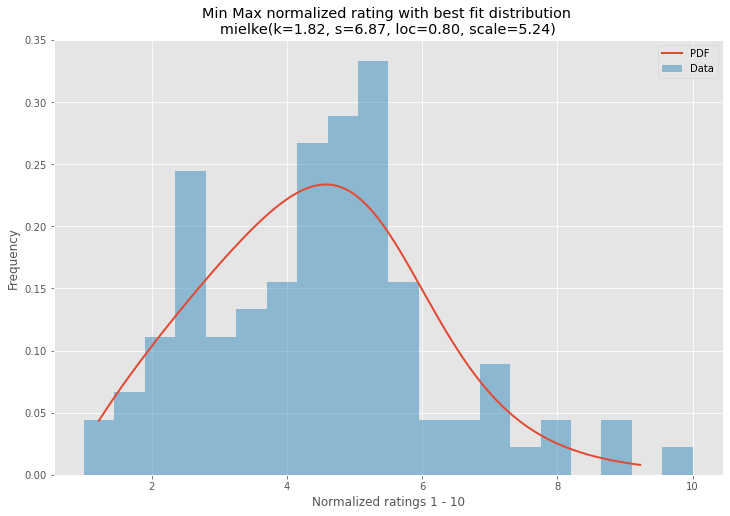

In [9]:


matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=20, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

#     DISTRIBUTIONS = [        
#         st.alpha,st.anglit,st.arcsine,
#         st.genextreme,st.gausshyper
#     ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf



# Plot for comparison
plt.figure(figsize=(12,8))
# ax = df.minmax_norm.plot(kind='hist', bins=20, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# ax = df.minmax_norm.plot(kind='hist', bins=20, alpha=0.5, color='blue', edgecolor = 'white')
ax = df.minmax_norm.hist(bins=20, alpha=0.5, density=True, color='blue', edgecolor = 'white')
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(df.minmax_norm, 20, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Min Max normalized rating\n All Fitted Distributions')
ax.set_xlabel(u'Normalized ratings 1 - 10')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
# df.minmax_norm.plot(kind='hist', bins=20, alpha=0.5, label='Data', legend=True, ax=ax)
df.minmax_norm.plot(kind='hist', bins=20, alpha=0.5, density=True, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Min Max normalized rating with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Normalized ratings 1 - 10')
ax.set_ylabel('Frequency')